# ResNet50 model

### ResNet50 with TI-RADS

## Get packages

In [8]:
import tensorflow as tf
import os
import random
import numpy as np
from tqdm import tqdm
import albumentations as A
import cv2

from skimage.io import imread
from skimage.io import imshow
from skimage.util import crop
from skimage.transform import resize
import matplotlib.pyplot as plt


from tensorflow import keras
from tensorflow.keras.utils import to_categorical

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras import models
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import r 
egularizers

# model / neural network
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
     

## Paths

In [103]:
TRAIN_PATH = 'archive/classification/tirads/no_frame/balance/train'
TEST_PATH = 'archive/classification/tirads/no_frame/balance/test'
VALID_PATH = 'archive/classification/tirads/no_frame/balance/validate'

In [104]:
input_size = (3,224,224)

## Load and Prepare Images

In [105]:

# # for neaug frame
# # divisible with 258: 2, 3, 6, 43, 86, 129 
# train_batchsize = 6
# # divisible with 52: 2, 4, 13 
# valid_batchsize = 4


# #for aug frame
# # divisible with 518: 2, 259.
# train_batchsize = 2
# # divisible with 52: 2, 4, 13 
# valid_batchsize = 4


# #for balance frame
# # divisible with 426: 2, 3, 6, 71, 142, 213
# train_batchsize = 6
#  # divisible with 52: 2, 4, 13 
# valid_batchsize = 4


# # for neaug no frame
# # divisible with 258: 2, 3, 6, 43, 86, 129 
# train_batchsize = 6
# # divisible with 52: 2, 4, 13 
# valid_batchsize = 4


# #for aug no frame
# # divisible with 518: 2, 259
# train_batchsize = 2
# # divisible with 52: 2, 4, 13 
# valid_batchsize = 4


#for balance no frane
# divisible with 426: 2, 3, 6, 71, 142, 213
train_batchsize = 6
# divisible with 18: 2, 3, 6, 9
valid_batchsize = 3


train_datagen = ImageDataGenerator(rescale=1./255
)

validation_datagen = ImageDataGenerator(rescale=1./255)
                                  

train_generator = train_datagen.flow_from_directory(
        TRAIN_PATH,  
        shuffle=True,
         batch_size=train_batchsize,
        target_size=input_size[1:],
        class_mode='categorical')  

validation_generator = validation_datagen.flow_from_directory(
        VALID_PATH,  
        target_size=input_size[1:],
        shuffle=True,
         batch_size=valid_batchsize,
        class_mode='categorical')

Found 426 images belonging to 6 classes.
Found 18 images belonging to 6 classes.


## Import the Model

In [106]:
resnet_50 = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
for layer in resnet_50.layers:
    layer.trainable = False

### Adjust the model

In [107]:
# We need to change the final layer accoding to the number of classes we have
model = Sequential()
model.add(resnet_50)

model.add(GlobalAveragePooling2D())

model.add(Dense(512, kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
          
model.add(Dense(256, kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
          
model.add(Dense(128, kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
          
model.add(Dense(64,kernel_regularizer=regularizers.l2(0.01)))  
model.add(Activation('relu'))
model.add(Dropout(0.5))
          
model.add(Dense(6, activation='softmax')) 
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_7  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_30 (Dense)            (None, 512)               1049088   
                                                                 
 activation_24 (Activation)  (None, 512)               0         
                                                                 
 dropout_24 (Dropout)        (None, 512)               0         
                                                                 
 dense_31 (Dense)            (None, 256)               131328    
                                                      

In [108]:
#Compile the model
model.compile(
    loss=keras.losses.BinaryCrossentropy(),
#     loss=keras.losses.CategoricalCrossentropy(), 
    optimizer=keras.optimizers.legacy.Adamax(learning_rate=0.001), 
    metrics=['accuracy']
)

## Train the model

In [109]:
class LearningRateLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate
        if isinstance(lr, tf.Variable) or tf.is_tensor(lr):
            lr = tf.keras.backend.get_value(lr)
        print(f" Epoch {epoch+1}: Learning rate is {lr:.6f}")

In [110]:
# Se antreneaza modelul
checkpoiter = tf.keras.callbacks.ModelCheckpoint('model_resnet1_tirads_aug.h5', verbose=1, save_best_only=True)
steps = train_generator.samples//train_generator.batch_size
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=4, min_lr=0.00001, verbose=1)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
    reduce_lr,
    LearningRateLogger(),
    checkpoiter,

]

results = model.fit(train_generator, 
                    validation_data=validation_generator, 
                    validation_steps=validation_generator.samples // validation_generator.batch_size,
                    steps_per_epoch = steps,
                    shuffle=True,
                    epochs=50, 
                    callbacks=callbacks,
                   )

Epoch 1/50
71/71 [==============================] - ETA: 0s - loss: 6.9660 - accuracy: 0.1291 Epoch 1: Learning rate is 0.001000

Epoch 1: val_loss improved from inf to 4.20509, saving model to model_resnet1_tirads_aug.h5


/Users/taras_lara/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


71/71 [==============================] - 63s 800ms/step - loss: 6.9660 - accuracy: 0.1291 - val_loss: 4.2051 - val_accuracy: 0.1667 - lr: 0.0010
Epoch 2/50
71/71 [==============================] - ETA: 0s - loss: 3.7577 - accuracy: 0.1761 Epoch 2: Learning rate is 0.001000

Epoch 2: val_loss improved from 4.20509 to 3.42107, saving model to model_resnet1_tirads_aug.h5
71/71 [==============================] - 54s 765ms/step - loss: 3.7577 - accuracy: 0.1761 - val_loss: 3.4211 - val_accuracy: 0.1667 - lr: 0.0010
Epoch 3/50
71/71 [==============================] - ETA: 0s - loss: 3.2474 - accuracy: 0.1737 Epoch 3: Learning rate is 0.001000

Epoch 3: val_loss improved from 3.42107 to 3.03674, saving model to model_resnet1_tirads_aug.h5
71/71 [==============================] - 53s 745ms/step - loss: 3.2474 - accuracy: 0.1737 - val_loss: 3.0367 - val_accuracy: 0.1667 - lr: 0.0010
Epoch 4/50
71/71 [==============================] - ETA: 0s - loss: 2.9108 - accuracy: 0.1479 Epoch 4: Learning r

Epoch 23/50
71/71 [==============================] - ETA: 0s - loss: 2.2716 - accuracy: 0.1995 Epoch 23: Learning rate is 0.000010

Epoch 23: val_loss improved from 2.26568 to 2.26058, saving model to model_resnet1_tirads_aug.h5
71/71 [==============================] - 27s 383ms/step - loss: 2.2716 - accuracy: 0.1995 - val_loss: 2.2606 - val_accuracy: 0.1667 - lr: 1.0000e-05
Epoch 24/50
71/71 [==============================] - ETA: 0s - loss: 2.2675 - accuracy: 0.1925 Epoch 24: Learning rate is 0.000010

Epoch 24: val_loss improved from 2.26058 to 2.25579, saving model to model_resnet1_tirads_aug.h5
71/71 [==============================] - 27s 383ms/step - loss: 2.2675 - accuracy: 0.1925 - val_loss: 2.2558 - val_accuracy: 0.1667 - lr: 1.0000e-05
Epoch 25/50
71/71 [==============================] - ETA: 0s - loss: 2.2686 - accuracy: 0.1667 Epoch 25: Learning rate is 0.000010

Epoch 25: val_loss improved from 2.25579 to 2.25068, saving model to model_resnet1_tirads_aug.h5
71/71 [========

Epoch 45/50
71/71 [==============================] - ETA: 0s - loss: 2.1347 - accuracy: 0.1737 Epoch 45: Learning rate is 0.000010

Epoch 45: val_loss improved from 2.12807 to 2.12024, saving model to model_resnet1_tirads_aug.h5
71/71 [==============================] - 27s 388ms/step - loss: 2.1347 - accuracy: 0.1737 - val_loss: 2.1202 - val_accuracy: 0.1667 - lr: 1.0000e-05
Epoch 46/50
71/71 [==============================] - ETA: 0s - loss: 2.1294 - accuracy: 0.1737 Epoch 46: Learning rate is 0.000010

Epoch 46: val_loss improved from 2.12024 to 2.11237, saving model to model_resnet1_tirads_aug.h5
71/71 [==============================] - 27s 387ms/step - loss: 2.1294 - accuracy: 0.1737 - val_loss: 2.1124 - val_accuracy: 0.1667 - lr: 1.0000e-05
Epoch 47/50
71/71 [==============================] - ETA: 0s - loss: 2.1216 - accuracy: 0.1549 Epoch 47: Learning rate is 0.000010

Epoch 47: val_loss improved from 2.11237 to 2.10420, saving model to model_resnet1_tirads_aug.h5
71/71 [========

## Results

In [111]:
print('Accuracy Score = ',np.max(results.history['val_accuracy']))
print('Loss Score = ',np.min(results.history['val_loss']))

Accuracy Score =  0.2777777910232544
Loss Score =  2.0799448490142822


### During training

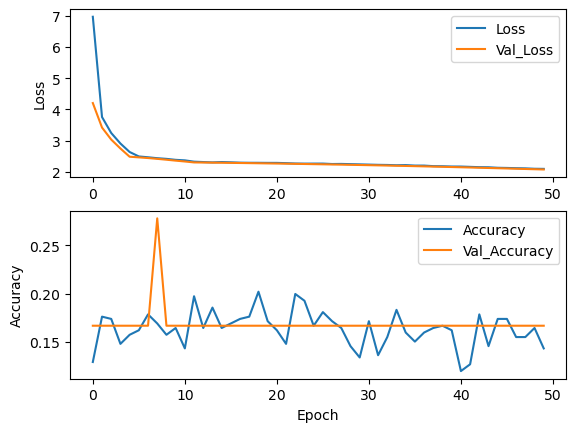

In [112]:
plt.figure()
plt.subplot(211)
loss_train_curve = results.history["loss"]
loss_val_curve = results.history["val_loss"]
plt.plot(loss_train_curve, label = "Loss")
plt.plot(loss_val_curve, label = "Val_Loss")
plt.legend(loc = 'upper right')
plt.ylabel("Loss")


plt.subplot(212)
acc_train_curve = results.history["accuracy"]
acc_val_curve = results.history["val_accuracy"]
plt.plot(acc_train_curve, label = "Accuracy")
plt.plot(acc_val_curve, label = "Val_Accuracy")
plt.legend(loc = 'upper right')
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

## Test the model

In [113]:
# divisible with 36:  2, 3, 4, 6, 9, 12, 18
test_batch_size = 6

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=input_size[1:],
    batch_size=test_batch_size,
    shuffle=False,
class_mode='categorical')
scores = model.evaluate(test_generator,workers=12)
print(scores)
target_names = list(test_generator.class_indices.keys())

Found 36 images belonging to 6 classes.
6/6 [==============================] - 1s 210ms/step - loss: 2.0763 - accuracy: 0.1389
[2.0762991905212402, 0.1388888955116272]


### Make prediction

In [114]:
test_generator.reset()

Y_pred = model.predict(test_generator, verbose=1)

y_pred = np.argmax(Y_pred, axis=-1)
classes = test_generator.classes

print(classes)
print(y_pred)

print(sum(y_pred==classes)/len(test_generator.classes))

6/6 [==============================] - 2s 204ms/step
[0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 5 5 5 5 5]
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
0.1388888888888889


### Confusion Matrix

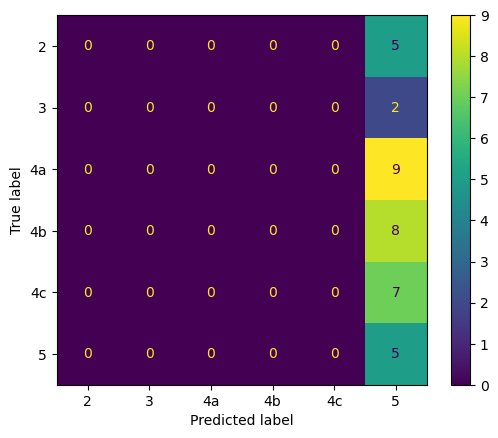

In [115]:
cm = confusion_matrix(classes, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

disp.plot()
plt.grid(False)
plt.show()

### Metrics

In [116]:
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

In [117]:
def Average(FP):
    return sum(FP) / len(FP)
FP=Average(FP)

def Average1(FN):
    return sum(FN) / len(FN)
FN=Average1(FN)

def Average2(TP):
    return sum(TP) / len(TP)
TP=Average2(TP)

def Average3(TN):
    return sum(TN) / len(TN)
TN=Average3(TN)


print("True positive=",TP)
print("True Negative=",TN)
print("False positive=",FP)
print("False Negative=",FN)

True positive= 0.8333333333333334
True Negative= 24.833333333333332
False positive= 5.166666666666667
False Negative= 5.166666666666667


In [118]:
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
#F1_SCORE
FSCO=(2*TP) / ((2*TP) +FP + FN) 
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

In [119]:
print("sensitivity=",round(TPR*100,3),"%")
print("precision=",round(PPV*100,3),"%")
print("Specificity=",round(TNR*100,3),"%")
print("F-score=",round(FSCO*100,3),"%")
print("ACCURACY=",round(ACC*100,3),"%")
print("FNR=",FNR*100,"%")
print("FPR=",FPR*100,"%")
print("NPV=",NPV*100,"%")

sensitivity= 13.889 %
precision= 13.889 %
Specificity= 82.778 %
F-score= 13.889 %
ACCURACY= 71.296 %
FNR= 86.11111111111111 %
FPR= 17.22222222222222 %
NPV= 82.77777777777777 %
